<a href="https://colab.research.google.com/github/fun-debug/demo/blob/main/d2l/convolutional-modern/batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Feb  6 04:50:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 114.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.

In [3]:
!pip install matplotlib==3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.0.0-cp38-cp38-linux_x86_64.whl size=11844462 sha256=0f4348a053ab4278ff7c1b2cb8ad23dc4be4c983732f7014b68c79ee7f95ddd0
  Stored in directory: /root/.cache/pip/wheels/a9/1e/ed/3e09c67472517aa5d81f8c15de6c81162d249ebe442e4f3007
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 req

In [4]:
!pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
  if not torch.is_grad_enabled():
    X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
  else:
    assert len(X.shape) in (2,4)
    if len(X.shape) ==2:
      mean=X.mean(dim=0)
      var=((X-mean)**2).mean(dim=0)
    else:
      mean=X.mean(dim=(0,2,3),keepdim=True)
      var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
    X_hat=(X-mean)/torch.sqrt(var+eps)
    moving_mean=momentum*moving_mean+(1.0-momentum)*mean
    moving_var=momentum*moving_var+(1.0-momentum)*var
  Y=gamma*X_hat+beta
  return Y,moving_mean.data,moving_var.data

In [12]:
class BatchNorm(nn.Module):
  # num_features：完全连接层的输出数量或卷积层的输出通道数。
  # num_dims：2表示完全连接层，4表示卷积层
  def __init__(self,num_features,num_dims):
    super().__init__()
    if num_dims==2:
      shape=(1,num_features)
    else:
      shape=(1,num_features,1,1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
    self.gamma=nn.Parameter(torch.ones(shape))
    self.beta=nn.Parameter(torch.zeros(shape))
    # 非模型参数的变量初始化为0和1
    self.moving_mean=torch.zeros(shape)
    self.moving_var=torch.ones(shape)
  def forward(self,X):
    # 如果X不在内存上，将moving_mean和moving_var
    # 复制到X所在显存上
    if self.moving_mean.device!=X.device:
      self.moving_mean=self.moving_mean.to(X.device)
      self.moving_var=self.moving_var.to(X.device)
    Y,self.moving_mean,self.moving_var=batch_norm(
        X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9
    )
    return Y

In [20]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(16*4*4,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),
    nn.Linear(120,84),BatchNorm(84,num_dims=2),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.271, train acc 0.900, test acc 0.821
22198.5 examples/sec on cuda:0


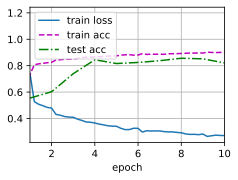

In [21]:
lr,num_epochs,batch_size=1.0,10,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

In [22]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([2.4247, 0.3337, 3.1410, 4.4137, 0.4022, 3.4092], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.2739,  0.2323, -0.9183,  2.3884,  0.5394,  3.4827], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

In [17]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
    nn.Linear(256,120),nn.BatchNorm1d(120),nn.Sigmoid(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.262, train acc 0.905, test acc 0.760
33498.5 examples/sec on cuda:0


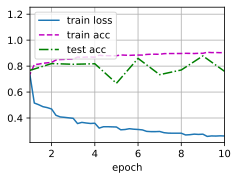

In [18]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())